In [1]:
import random
import os
import shutil


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization
from keras.preprocessing import image as k_image
from keras.models import Model, Sequential
from keras import backend as K 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import applications
from keras import optimizers
from keras import losses
from keras import models
from keras import layers


from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# -----------Constants-----------
RANDOM_SEED = 666
ROOT_DIR = 'drive/MyDrive/data/archive/all/All/'
LABELS = ('Pneumonia','Healthy')
img_width = 224
img_height = 224

In [4]:
# -----------Making results reproducable-----------
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
# ----------Load data and printing statisctics--------------
df = pd.read_csv(ROOT_DIR + 'GTruth.csv')
print(df.head())
print(df.info())

          Id  Ground_Truth
0  643781546             1
1  540270208             0
2  585452583             1
3  341665171             0
4  940983956             1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Id            5856 non-null   int64
 1   Ground_Truth  5856 non-null   int64
dtypes: int64(2)
memory usage: 91.6 KB
None


(4273, 1583)


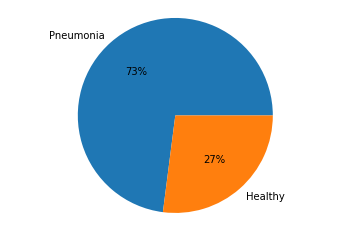

In [6]:
# ----------Printing some metrics about data----------
counts = (
    np.count_nonzero(df['Ground_Truth']),
    np.count_nonzero(df['Ground_Truth'] == 0)
    )
print(counts)

plt.pie(counts, labels=LABELS, autopct='%1.f%%')
plt.axis('equal')
plt.show()

Number:  1 Filename:  668356357.jpeg  Result:  Healthy
Number:  2 Filename:  686800246.jpeg  Result:  Healthy
Number:  3 Filename:  686753660.jpeg  Result:  Healthy
Number:  4 Filename:  681686270.jpeg  Result:  Healthy
Number:  5 Filename:  690117872.jpeg  Result:  Healthy
Number:  6 Filename:  683575325.jpeg  Result:  Pneumonia
Number:  7 Filename:  688777938.jpeg  Result:  Pneumonia
Number:  8 Filename:  685090619.jpeg  Result:  Healthy
Number:  9 Filename:  690701766.jpeg  Result:  Pneumonia
Number:  10 Filename:  689332156.jpeg  Result:  Healthy
Number:  11 Filename:  693759901.jpeg  Result:  Pneumonia
Number:  12 Filename:  685841845.jpeg  Result:  Healthy
Number:  13 Filename:  693676739.jpeg  Result:  Healthy
Number:  14 Filename:  691155559.jpeg  Result:  Pneumonia


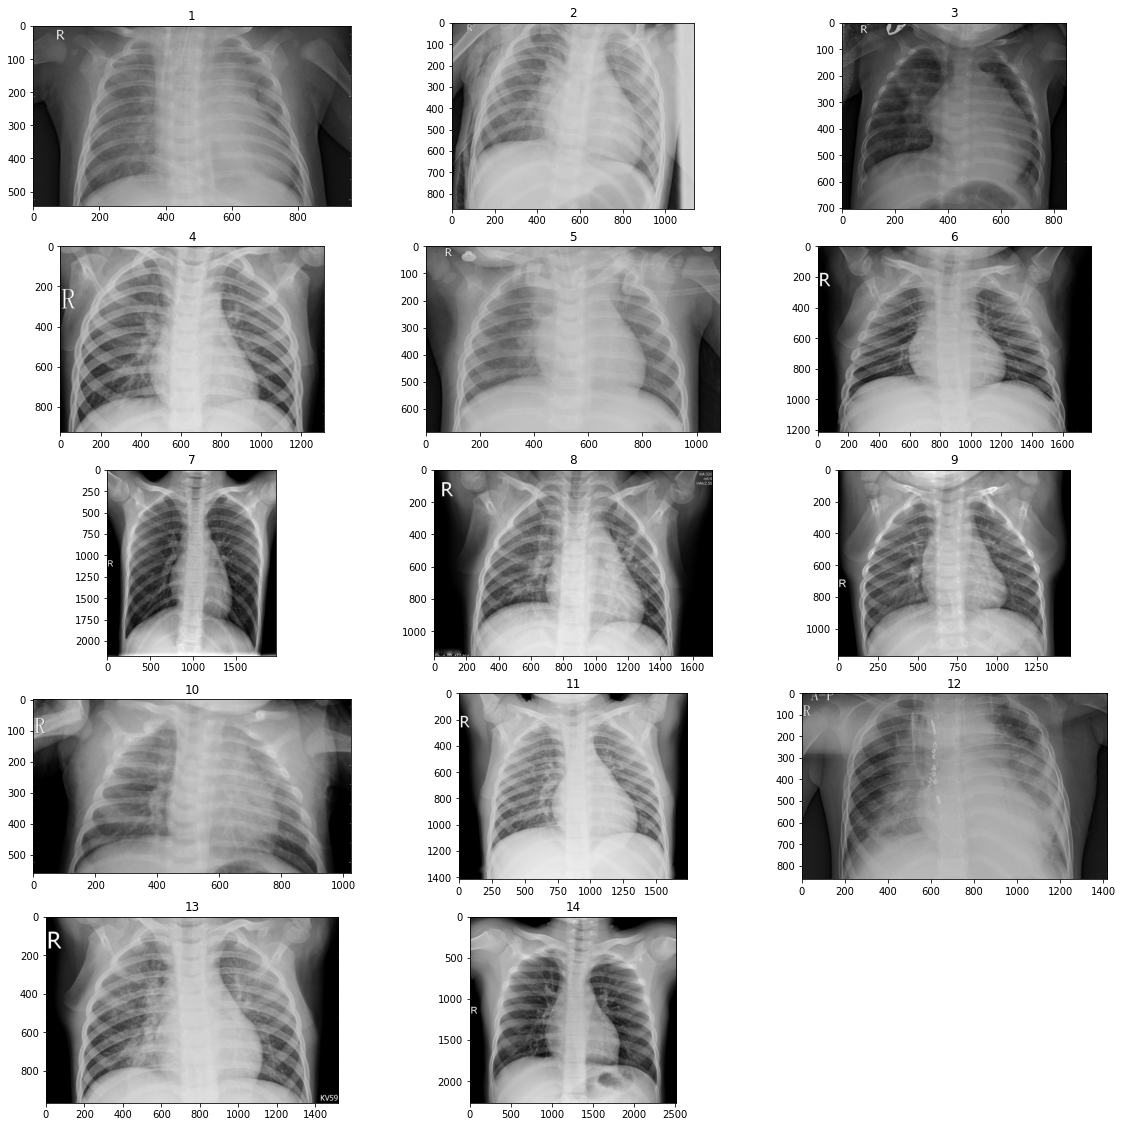

In [7]:
#  ----------Plotting images----------
max_number = 15
images_list = os.listdir(ROOT_DIR)
sample_of_images = [(file_name, image.imread(ROOT_DIR + file_name))
  for i, file_name in enumerate(images_list)
  if (file_name.endswith('.jpeg') or file_name.endswith('.jpg')) 
  and len(images_list) // 2 < i <  len(images_list) // 2 + max_number
]

rows_number, columns_number = 5, 3
fig = plt.figure(figsize=(15,15))
for i, img in enumerate(sample_of_images):
  print('Number: ', i + 1, 'Filename: ', img[0], ' Result: ', 
        LABELS[df.loc[df['Id'] == int(img[0].split('.')[0]),'Ground_Truth'].values[0]])
  
  fig.add_subplot(rows_number, columns_number, i + 1)
  plt.title(i + 1)
  plt.imshow(img[1], cmap=plt.cm.gray)

plt.subplots_adjust(left=1, right=2, bottom=1, top=2)
plt.show()

In [8]:
image_label_dict = dict(zip(df['Id'].values, df['Ground_Truth'].values))

In [9]:
def read_img(fileid):
  img = k_image.load_img(str(fileid), target_size=(224,224))
  img = np.reshape(img,(224,224, 3))
  img = img.astype(np.float32) / 255
  return img

In [10]:
data, labels = [], []
for fileid in os.listdir(ROOT_DIR):
  if fileid.endswith('.jpeg') or fileid.endswith('.jpg'):
    try:
      labels.append(image_label_dict.get(int(fileid.split('.')[0])))
      data.append(read_img(os.path.join(ROOT_DIR, fileid)))
    except ValueError:
      labels.append(image_label_dict.get(int(fileid.split('.')[0][:-4])))
      data.append(read_img(os.path.join(ROOT_DIR, fileid)))
    

In [ ]:
from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
    X_train=X_train.reshape(X_train.shape[0],3,img_width,img_height)
    X_cv=X_cv.reshape(X_cv.shape[0],3,img_width,img_height)
    X_test=X_test.reshape(X_test.shape[0],3,img_width,img_height)
    
else:
    input_shape = (img_width, img_height, 3)
    X_train=X_train.reshape(X_train.shape[0],img_width,img_height,3)
    X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,3)
    X_test=X_test.reshape(X_test.shape[0],img_width,img_height,3)
    

In [11]:
#Train Test Split
X_train, X_1, y_train, y_1 = train_test_split(np.array(data), np.array(labels), test_size=0.2, random_state=42,stratify=labels)

#Train Test Split
X_cv, X_test, y_cv, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42,stratify=y_1)

In [16]:
#Model Defining
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),
                activation='relu',
                input_shape=input_shape,
                kernel_initializer='he_normal'))  
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid',kernel_initializer='glorot_normal'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [20]:
#Model Compile
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

# Train
his=model.fit(X_train,y_train,batch_size=32,epochs=20,verbose=1,validation_data=(X_cv,y_cv))


Epoch 1/20
147/147 [==============================] - 324s 2s/step - loss: 0.0332 - accuracy: 0.9911 - val_loss: 0.2511 - val_accuracy: 0.9329
Epoch 2/20
147/147 [==============================] - 322s 2s/step - loss: 0.0488 - accuracy: 0.9828 - val_loss: 0.3182 - val_accuracy: 0.9286
Epoch 3/20
147/147 [==============================] - 322s 2s/step - loss: 0.0548 - accuracy: 0.9827 - val_loss: 0.1587 - val_accuracy: 0.9563
Epoch 4/20
147/147 [==============================] - 321s 2s/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 0.1673 - val_accuracy: 0.9531
Epoch 5/20
147/147 [==============================] - 324s 2s/step - loss: 0.0371 - accuracy: 0.9891 - val_loss: 0.1822 - val_accuracy: 0.9521
Epoch 6/20
147/147 [==============================] - 317s 2s/step - loss: 0.0209 - accuracy: 0.9936 - val_loss: 0.1643 - val_accuracy: 0.9542
Epoch 7/20
147/147 [==============================] - 315s 2s/step - loss: 0.0227 - accuracy: 0.9939 - val_loss: 0.2050 - val_accuracy: 0.9563

In [21]:
model

In [22]:
model_json = model.to_json()

In [23]:
model.save_weights(ROOT_DIR+'weights.h5')

In [24]:
with open(ROOT_DIR+'model.json','w') as f:
  f.write(model_json)